In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from keras import metrics
import keras.backend as K
from keras.utils import to_categorical, image_dataset_from_directory
import cv2
import glob
from tensorflow.python.client import device_lib
from sklearn.multiclass import OneVsRestClassifier
from roc_multiclass import roc_multiclass
from precision_recall_multiclass import precision_recall_multiclass

keras.backend.clear_session()



### Load Train Set

In [2]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\train"
IMAGE_SIZE = (208, 176)
train_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))


Found 4094 files belonging to 4 classes.


### Load Validation Set
<i>-for training-<i>

In [3]:
# load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_ds = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=True, 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1027 files belonging to 4 classes.


### Load Validation Set
<i>-deconstruct for evaluation-<i>

In [4]:
# NOT SHUFFLED load dataset from drive
PATH = "F:\\MRI_class\\data\\Alzheimer_s Dataset\\validation"
IMAGE_SIZE = (208, 176)
val_no_shuffle = image_dataset_from_directory(
                                        PATH, 
                                        seed=10, 
                                        shuffle=False,              #<--- 
                                        image_size=IMAGE_SIZE, 
                                        batch_size=32
                                        )

# one hot encode the labels to fit into the cnn layers
val_no_shuffle = val_no_shuffle.map(lambda x, y: (x, tf.one_hot(y, depth=4)))

Found 1027 files belonging to 4 classes.


In [5]:
# seperate images and labels for evaluation.

X_val = []
y_val = []

for img, label in val_no_shuffle.unbatch():
    X_val.append(img.numpy())
    y_val.append(label.numpy())
    
X_val = np.array(X_val)
y_val = np.array(y_val)

X_val, y_val = shuffle(X_val, y_val, random_state=10)

### Visualize Example Brains

f:\alzheimer-classification\envwin\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


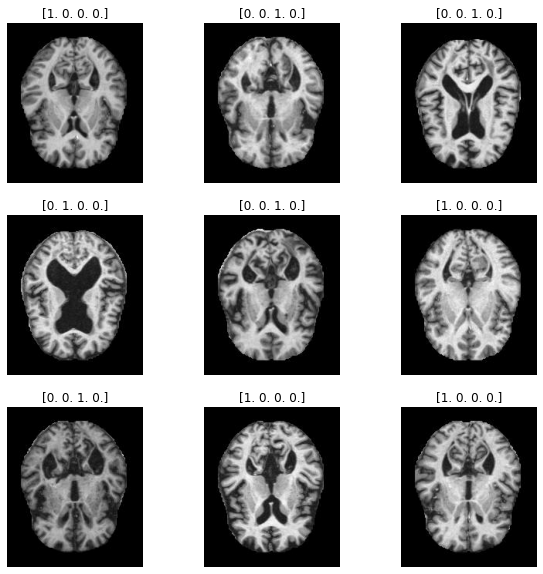

In [6]:
# # plot some example images from loaded set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([labels[i].numpy()][0])
    plt.axis("off")

### Build CNN Architecture and Model Fitting

In [7]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(208, 176, 3)))
model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [8]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(rate=0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))


In [9]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=train_ds.cardinality().numpy()*100,
    decay_rate=1,
    staircase=False)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')


In [10]:
#compiling the model architecture and start fit
keras.backend.clear_session()
model.compile(optimizer=optimizer,
              loss="CategoricalCrossentropy",
              metrics=[metrics.Precision(), metrics.Recall(), metrics.AUC()])


with tf.device("/gpu:0"):
    history = model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=20, 
                        shuffle=True,               #not sure if used with batched tf dataset
                        )
                        
                    

Epoch 1/20
128/128 [==============================] - 11s 51ms/step - loss: 1.0717 - precision: 0.5662 - recall: 0.2894 - auc: 0.7854 - val_loss: 0.8989 - val_precision: 0.7879 - val_recall: 0.2785 - val_auc: 0.8475
Epoch 2/20
128/128 [==============================] - 6s 43ms/step - loss: 0.9172 - precision: 0.6946 - recall: 0.3544 - auc: 0.8399 - val_loss: 0.8605 - val_precision: 0.8010 - val_recall: 0.3096 - val_auc: 0.8716
Epoch 3/20
128/128 [==============================] - 6s 44ms/step - loss: 0.8125 - precision: 0.7165 - recall: 0.4433 - auc: 0.8734 - val_loss: 0.7468 - val_precision: 0.7151 - val_recall: 0.5180 - val_auc: 0.8929
Epoch 4/20
128/128 [==============================] - 6s 44ms/step - loss: 0.6635 - precision: 0.7586 - recall: 0.6087 - auc: 0.9176 - val_loss: 0.5468 - val_precision: 0.7854 - val_recall: 0.7235 - val_auc: 0.9438
Epoch 5/20
128/128 [==============================] - 6s 43ms/step - loss: 0.5618 - precision: 0.7830 - recall: 0.6830 - auc: 0.9397 - val_

### Model Evaluation

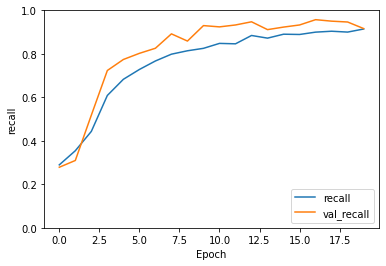

In [11]:
#print val vs accuracy

plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label = 'val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [12]:
y_pred = model.predict(X_val, batch_size=1, verbose=1)

test_loss, test_prec, test_rec, test_auc  = model.evaluate(val_ds, verbose=2)

1027/1027 [==============================] - 2s 1ms/step
33/33 - 1s - loss: 0.2126 - precision: 0.9262 - recall: 0.9163 - auc: 0.9910 - 608ms/epoch - 18ms/step


MACRO ROC AUC SCORE: 0.8230999005211679


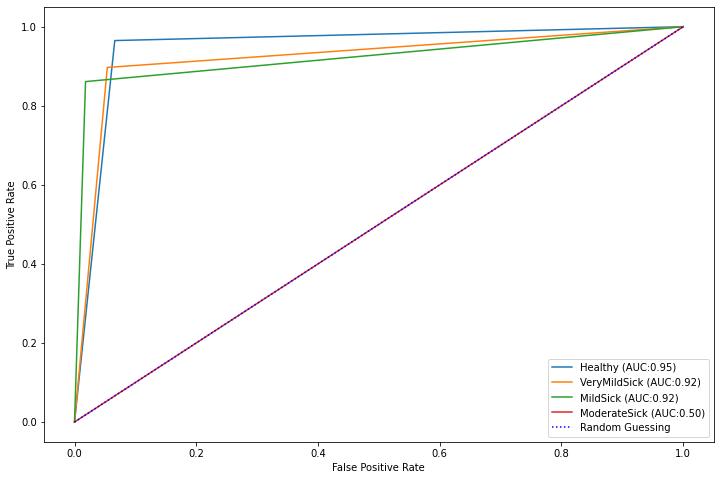

In [13]:
roc_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'],"macro")

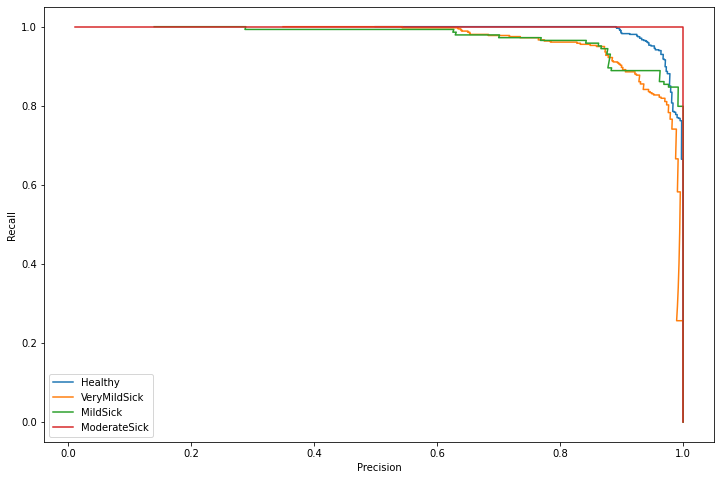

In [14]:
precision_recall_multiclass(y_pred,y_val,['Healthy','VeryMildSick','MildSick','ModerateSick'])

In [15]:
#!mkdir -p saved_model2
#model.save("saved_model/model2")